# this notebook parse the **patch** data



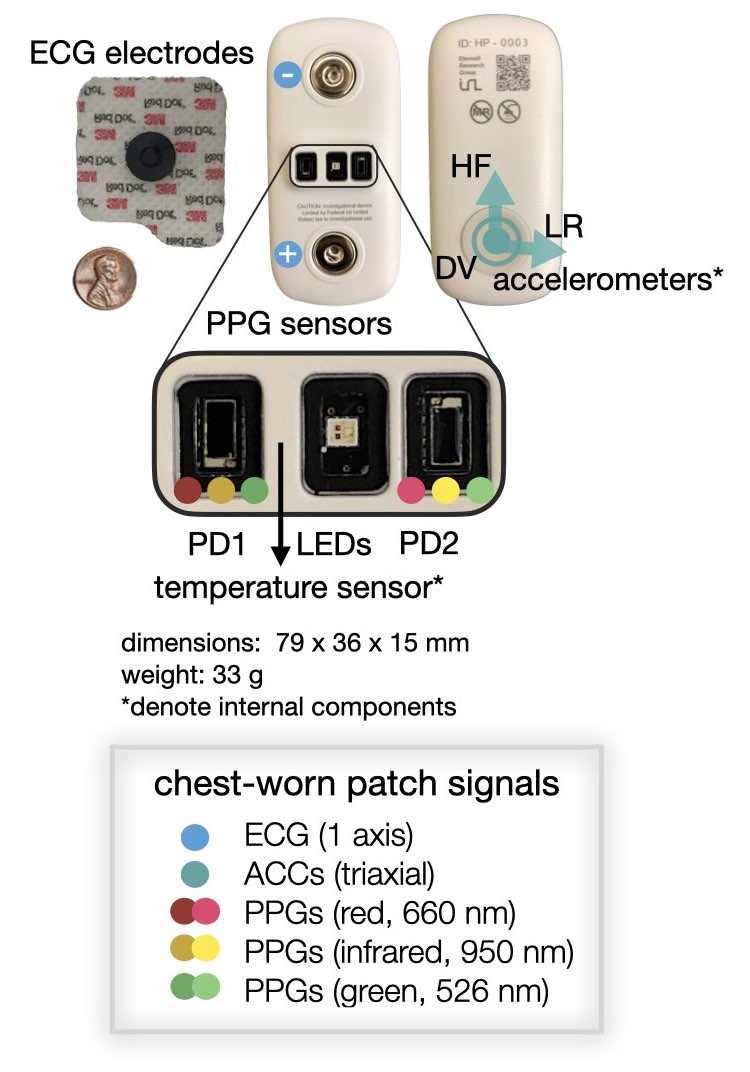





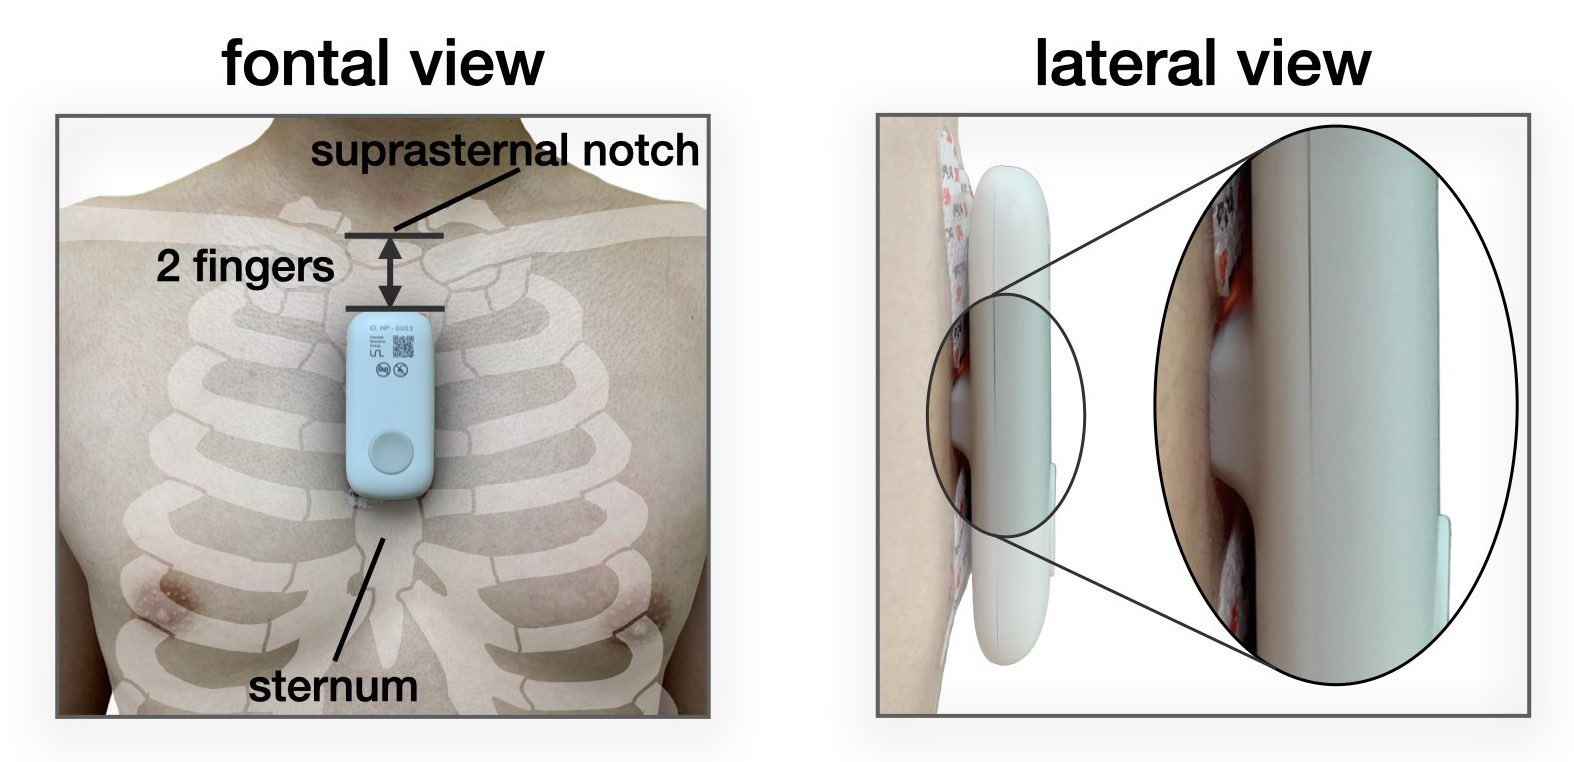

In [1]:
import numpy as np
import argparse

import json

import os
import math
from math import sin

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as pyo
import plotly.graph_objs as go

i_seed = 0

import sys
sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from PatchWand import *
from filters import *
from setting import *
from plotting_tools import *
from stage1_patch import *
from PatchParser import *
from TimeStampReader import *


from importlib import reload
%load_ext autoreload
%autoreload 2

In [2]:
parser = argparse.ArgumentParser(description='SpO2_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--subject_id', metavar='subject_id', help='subject_id',
                    default='sub101')

# checklist 3: comment first line, uncomment second line
args = parser.parse_args(['--input_folder', '../../data/raw/', 
                          '--output_folder', '../../data/stage1/',
                          '--subject_id', 'sub212',
                         ])
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/raw/', output_folder='../../data/stage1/', subject_id='sub212')


In [3]:
inputdir = args.input_folder
outputdir = args.output_folder
subject_id = args.subject_id
# position = args.position

if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
outputdir_sub = outputdir+subject_id+'/patch/'

if not os.path.exists(outputdir_sub):
    os.makedirs(outputdir_sub)

# read data from sternum, clavicle, and ribcage

In [4]:
raw_dict = {}

for sub_file in os.listdir(inputdir):

    if 'sub' not in sub_file:
        continue

    if sub_file.split('_')[0] != subject_id:
        continue
    for data_file in os.listdir(inputdir+sub_file):

#         if position in data_file:
#         if position in list_positions: 
        for position in list_positions:
            if position in data_file:
                print('\n', position)
                fileName = inputdir+sub_file+'/'+data_file
                print(fileName)

                file = open(fileName, mode='rb')
                fileContent = file.read()
                raw_dict[position] = parse(fileContent, header = True, print_updates = True, isConvUnits = True)
                raw_dict[position]['subject_id'] = subject_id


 ribcage
../../data/raw/sub212/HP-0022_20220302_183959_ribcage.bin
Device name: HP-0022
Last sync time: Wed Mar  2 18:39:59 2022 UTC
Accel Size: 7584752
PPG Size: 503856
ECG Size: 3774220
Environmental Size: 15168
AST Time Length: 7554.461669921875
83229988 100.0% done                      

STATS:
Measurement Length: 7554.38 seconds
File Size: 83230.208 kbytes
Average data rate: 11017.48 bytes/second
Theoretical uncompressed data rate: 17255.26 bytes/second
PPG is 10.9% of the data
ECG is 14.89% of the data
Accel is 52.2% of the data
Environmental is 0.13% of the data
AST is 9.14% of the data
Data Flag is 9.11% of the data
time ellapsed: 23.590 seconds
parse speed: 3528245.918 bytes/second
parse speed: 320.241 dataSeconds/second

 sternum
../../data/raw/sub212/HP-0238_20220302_183920_sternum.bin
Device name: HP-0238
Last sync time: Wed Mar  2 18:39:20 2022 UTC
Accel Size: 7503868
PPG Size: 491834
ECG Size: 3718775
Environmental Size: 15006
AST Time Length: 7442.878662109375
80854251 

In [5]:
# plt.plot(raw_dict['clavicle']['ecg_time'][:11500], raw_dict['clavicle']['ecg'][:11500])

In [6]:
# plt.plot(raw_dict['sternum']['ecg_time'][50000:50500], raw_dict['sternum']['ecg'][50000:50500])

# Do interpolation

In [7]:
patch_dict = {}
df_patch = {}
for position in raw_dict.keys():
    print(position)
    patch_dict = data_interpolation(raw_dict[position], FS_RESAMPLE=FS_RESAMPLE)
    df_patch[position] = pd.DataFrame(patch_dict)


ribcage
sternum
clavicle


# inspect the taps

In [8]:
# position_check = 'clavicle'
# position_check = 'ribcage'
position_check = 'sternum'

In [9]:
with open('patch_tap_times.json', 'r') as f:
    patch_tap_times = json.load(f)[0]
    
    
# if True:
if subject_id not in patch_tap_times['sternum']:
# if subject_id in patch_tap_times['sternum']:
# Create traces
    fig = make_subplots(specs=[[{'secondary_y': True}]])
    df = df_patch[position_check]

    t_start = 10*60
# #     t_start = df_patch['time'].max()-20*60
    t_end = df['time'].max()-60*60
#     t_start = df['time'].max()-60*60
#     t_end = df['time'].max()-40*60
    
    
    df = df[(df['time']>t_start) & (df['time']<t_end)] # ignore the last 60minutes because the study is at least 60 minute long prior to stop recording
    downsample_factor = 5

    alpha = 0.5

    v_ECG = df['ECG'].values
    v_accelX = df['accelX'].values
    v_accelY = df['accelY'].values
    v_accelZ = df['accelZ'].values
    
    ts = df['time'].values
    
    
    fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_ECG[::downsample_factor],
                        mode='lines',
                        name='ecg',
                             opacity=alpha,
                          line=dict(color=color_dict[sync_color_dict['ECG']])),
                  secondary_y=True,)

    fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_accelX[::downsample_factor],
                        mode='lines',
                        name='accelX',
                             opacity=alpha,
                          line=dict(color=color_dict[sync_color_dict['accelX']])),
                  secondary_y=False,)

    fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_accelY[::downsample_factor],
                        mode='lines',
                        name='accelY',
                             opacity=alpha,
                          line=dict(color=color_dict[sync_color_dict['accelY']])),
                  secondary_y=False,)

    fig.add_trace(go.Scatter(x=ts[::downsample_factor], y=v_accelZ[::downsample_factor],
                        mode='lines',
                        name='accelZ',
                             opacity=alpha,
                          line=dict(color=color_dict[sync_color_dict['accelZ']])),
                  secondary_y=False,)

    # Add figure title
    fig.update_layout(
        title_text="inspect taps"
    )

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>signal (a.u.)</b>", secondary_y=False)

    fig.update_xaxes(title_text="<b>time (sec)</b>")
    fig.update_layout(plot_bgcolor='rgb(255,255,255)')

    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)


    fig.show()
    sys.exit()
else:
    tap_time = patch_tap_times['sternum'][subject_id]
    print(tap_time)


1061.464


# adjust the time vector of the patch accordingly

In [10]:
try:
    print('The patch is tapped by the subject at {:.2f} since device startup'.format(patch_tap_times['sternum'][subject_id]))
    df_patch['sternum']['time'] = df_patch['sternum']['time']-tap_time
    print('Now, that tap time is set to 0 sec')

except:
    print('please go back to the last cell to find tap time for '+subject_id)

The patch is tapped by the subject at 1061.46 since device startup
Now, that tap time is set to 0 sec


In [11]:
import os

for subdir, dirs, files in os.walk(inputdir):
#     print(subdir, dirs, files)
    for dir_one in dirs:
        if subject_id in dir_one:
            inputdir_sub = inputdir + dir_one + '/'

In [12]:
for filename in os.listdir(inputdir_sub):
    if 'tm_backup' in  filename:
        if 'processed' in filename:
            print(filename)
            tm_filePath = inputdir_sub + filename


tm_backup_0302_sub212_processed.txt


# read timestamps, use readTimeStampData to parse data

In [13]:
ts_dict = readTimeStampData(tm_filePath, dateBegin=None, dateEnd=None)

df_timestamps = pd.DataFrame(ts_dict, columns=['datetime', 'note'])
df_timestamps = df_timestamps.sort_values(by=['datetime'], ascending=True)


# create the timestamps dictionary

In [14]:
def ts2sec(df_timestamps, task_name, ith_taskname):
    """
        this function provides the name of the task and the time in sec of the labeled task
        TODO: provide documentation

    """
    datetime = df_timestamps[df_timestamps['note']==task_name].reset_index(drop=True).iloc[ith_taskname]['datetime']
    seconds = datetime.timestamp()
    
    task_renamed = task_name+' '+str(ith_taskname)
    
    return task_renamed, seconds


In [15]:
task_ts_dict = {}

for task_name in df_timestamps['note'].unique():
    N_rows = df_timestamps[df_timestamps['note']==task_name].shape[0]

    for ith_taskname in range(N_rows):
        task_renamed, time_in_s = ts2sec(df_timestamps, task_name, ith_taskname)
        task_ts_dict[task_renamed] = time_in_s

# set 3 Taps to t=0
t_start = task_ts_dict['3 Taps 0']
for key in task_ts_dict:
    task_ts_dict[key] = task_ts_dict[key] - t_start
    
# # rename Device Sync
# for key in task_ts_dict:
#     for position in list_positions:
#         if position in key:
#             task_ts_dict['Device Sync {} 0'.format(position)] = task_ts_dict[key]
#             del task_ts_dict[key]

In [16]:
position1 = 'sternum'
position2 = 'clavicle'

for key in task_ts_dict:
    if position1 in key:
        task_ts_1 = task_ts_dict[key]
    if position2 in key:
        task_ts_2 = task_ts_dict[key]

task_ts_offset = task_ts_2 - task_ts_1
print('position 1 starts recording {:.2f} s'.format(task_ts_1))
print('position 2 starts recording {:.2f} s'.format(task_ts_2))
print('position 1 starts recording {:.2f} s earlier than position 2'.format(task_ts_offset))

# task_ts_1, task_ts_2, task_ts_offset

position 1 starts recording -752.57 s
position 2 starts recording -1043.72 s
position 1 starts recording -291.15 s earlier than position 2


In [17]:
# df_patch['sternum']
# df_patch['clavicle']

In [18]:
with open('sternum_ecg_trange.json', 'r') as f:
    sternum_ecg_trange = json.load(f)[0]
sternum_ecg_trange

{'sub105': {'t_start': 493, 't_end': 555},
 'sub115': {'t_start': 500, 't_end': 2000},
 'sub116': {'t_start': 500, 't_end': 2000},
 'sub117': {'t_start': 100, 't_end': 3000},
 'sub118': {'t_start': 500, 't_end': 2000},
 'sub121': {'t_start': 500, 't_end': 2000}}

In [19]:

def lag_finder(t1, t1_start, t1_end, t_offset, y1, t2, y2, task_ts_offset, Fs, subject_id, fig_name, debug=True, outputdir=None, show_plot=False):
    # TODO: simplify this...
    
    t1_temp = t1.copy()
    y1_temp = y1.copy()
    t2_temp = t2.copy()
    y2_temp = y2.copy()
    
    # Rough Estimate    
    
    # store start of t2 in t2_start_temp (likely to be 0s)
    t2_start_temp = t2[0]
    # the start of t2 should be t1[0] + task_ts_offset instead of 0s
    t2_start_adjusted = t1[0] + task_ts_offset
    # shift t2 so it starts at t2_start_adjusted (now t1 and t2 are more or less on the same time zone)
    t2 = t2 - t2[0] + t2_start_adjusted

    # for signal 2, we will look at the data starting from t1_start - t_offset to t1_end + t_offset
    t2_start = t1_start - t_offset
    t2_end = t1_end + t_offset

    # get these segemnts for y1 and t1
    y1 = y1[(t1>=t1_start) & (t1<=t1_end)]
    t1 = t1[(t1>=t1_start) & (t1<=t1_end)]

    # get these segemnts for y2 and t2
    y2 = y2[(t2>=t2_start) & (t2<=t2_end)]
    t2 = t2[(t2>=t2_start) & (t2<=t2_end)]
    # now, let t2 start at t1[0]
    t2 = t2 - t2[0] + t1[0] 

    # filter the ECG signals
    y1 = get_padded_filt(y1, filter_padded=5, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=Fs)
    y2 = get_padded_filt(y2, filter_padded=5, lowcutoff=FILT_ECG[0], highcutoff=FILT_ECG[1], Fs=Fs)
    
    # get the length of these signals, find the longer one (store the size in n)
    n1 = len(y1)
    n2 = len(y2)
    n = max(n1, n2)

    # create two signals with size of n, fill in y1 and y2, if y1 or y2 not long enough, the signals will fill in 0's
    y1_filled = np.zeros(n)
    y2_filled = np.zeros(n)
    y1_filled[:n1] = y1
    y2_filled[:n2] = y2

    # compute cross correlation 
    corr = signal.correlate(y2_filled, y1_filled, mode='same')
    # corr = signal.correlate(y2_filled, y1_filled, mode='same') / np.sqrt(signal.correlate(y1_filled, y1_filled, mode='same')[int(n1/2)] * signal.correlate(y2_filled, y2_filled, mode='same')[int(n2/2)])
    # create the delay array
    delay_arr = np.linspace(-0.5*n/Fs, 0.5*n/Fs, n)
    # find the delay that maximizes the xcorr
    t_delay = delay_arr[np.argmax(np.abs(corr))]
    # comptue t2_delay_s, can be used directly on the dataframe 'time' column
    t2_delay_s = - t2_start_temp + t2_start_adjusted + t1_start - t2_start - t_delay

    print('t1 starts at {}, t2 starts at {}'.format(t1_start, t2_start_temp))
    print('t2_delay_s is {}s'.format(t2_delay_s))
    
    if debug:
        fontsize = 20
    
        t2_adjusted = t2 - t_delay

        fig = plt.figure(figsize=(20, 8), dpi=100, facecolor='white')

        fontdict = {'size': 20}

        alpha = 0.5

        # plot xcorr
        ax1 = fig.add_subplot(4,1,1)
        ax1.plot(delay_arr, corr)
        ax1.set_title('Lag: ' + str(np.round(t_delay, 3)) + ' s', fontsize=fontsize)
        ax1.set_xlabel('Lag', fontsize=fontsize)
        ax1.set_ylabel('Correlation coeff', fontsize=fontsize)

        # plot plot signals before alignment (assume they start at the same time)
        ax2 = fig.add_subplot(4,1,2)
        ax2.plot(t1, y1, c='steelblue', alpha=alpha, label='y1')

        ax2_tw = ax2.twinx()
        ax2_tw.plot(t2, y2, c='firebrick', alpha=alpha, label='y2')
        ax2.set_title('before alignment')

        ax2.legend(frameon=True, loc='upper right')
        ax2_tw.legend(frameon=True, loc='lower right')
        
        #  plot signals after alignment (y2 will be shifted)
        ax3 = fig.add_subplot(4,1,3)
        ax3.plot(t1, y1, c='steelblue', alpha=alpha)
        ax3_tw = ax3.twinx()
        ax3_tw.plot(t2_adjusted, y2, c='firebrick', alpha=alpha)
        ax3.set_title('after alignment')

        #  plot signals after alignment (choose a 50s close to baseline)
        t_start = 50
        t_end = 100

        print('t_start: {}s, t_end: {}s since the 3 Taps'.format(t_start, t_end))

        ax4 = fig.add_subplot(4,1,4)
        t1_mask = (t1_temp > t_start) & (t1_temp < t_end)
        ax4.plot(t1_temp[t1_mask], y1_temp[t1_mask], c='steelblue', alpha=alpha)
        ax4_tw = ax4.twinx()

        t2_temp_adjusted = t2_temp + t2_delay_s 
        t2_mask = (t2_temp_adjusted > t_start) & (t2_temp_adjusted < t_end)
        ax4_tw.plot(t2_temp_adjusted[t2_mask], y2_temp[t2_mask], c='firebrick', alpha=alpha)
        ax4.set_title('after alignment (zoom in)')
        
        fig.suptitle(fig_name, fontsize=fontsize*1.1)
        fig.tight_layout()
        
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'xcorr_{}.png'.format(fig_name), facecolor=fig.get_facecolor(), bbox_inches='tight')
    
    return t2_delay_s

In [20]:
t2_delay_s = {}

for position2 in ['clavicle', 'ribcage']:

    position1 = 'sternum'
    print('\nsyncing {} to {}'.format(position2, position1))
    # position2 = 'clavicle'

    for key in task_ts_dict:
        if position1 in key:
            task_ts_1 = task_ts_dict[key]
        if position2 in key:
            task_ts_2 = task_ts_dict[key]

    task_ts_offset = task_ts_2 - task_ts_1
    print('position 1 starts recording {:.2f} s'.format(task_ts_1))
    print('position 2 starts recording {:.2f} s'.format(task_ts_2))
    print('position 1 starts recording {:.2f} s earlier than position 2'.format(task_ts_offset))
    
    t1 = df_patch['sternum']['time'].values
    y1 = df_patch['sternum']['ECG'].values
    t2 = df_patch[position2]['time'].values
    y2 = df_patch[position2]['ECG'].values

    t_offset = 500

    if subject_id in sternum_ecg_trange:
        t1_start = sternum_ecg_trange[subject_id]['t_start']
        t1_end = sternum_ecg_trange[subject_id]['t_end']
    else:
        t1_start = 1000
        t1_end = 1200

    print('Will use ECG from {}-{} s on the sternum patch'.format(t1_start, t1_end))

    print('Will use ECG from ~{}-{} s on the {} patch'.format(t1_start-t_offset, t1_end+t_offset, position2))
    
    fig_name = subject_id + '_' + position2

    t2_delay_s[position2] = lag_finder(t1, t1_start, t1_end,t_offset, y1, t2, y2, task_ts_offset, FS_RESAMPLE, subject_id, fig_name, outputdir=outputdir_sub, show_plot=False)



syncing clavicle to sternum
position 1 starts recording -752.57 s
position 2 starts recording -1043.72 s
position 1 starts recording -291.15 s earlier than position 2
Will use ECG from 1000-1200 s on the sternum patch
Will use ECG from ~500-1700 s on the clavicle patch
t1 starts at 1000, t2 starts at 0.0
t2_delay_s is -1038.9086210774371s
t_start: 50s, t_end: 100s since the 3 Taps

syncing ribcage to sternum
position 1 starts recording -752.57 s
position 2 starts recording -1027.08 s
position 1 starts recording -274.51 s earlier than position 2
Will use ECG from 1000-1200 s on the sternum patch
Will use ECG from ~500-1700 s on the ribcage patch
t1 starts at 1000, t2 starts at 0.0
t2_delay_s is -1023.1086237725425s
t_start: 50s, t_end: 100s since the 3 Taps


In [21]:
# if (subject_id in patch_tap_times['ribcage'].keys()) & (subject_id in patch_tap_times['clavicle'].keys()):
#     t2_delay_s['ribcage'] = patch_tap_times['ribcage'][subject_id] - patch_tap_times['sternum'][subject_id]
#     t2_delay_s['clavicle'] = patch_tap_times['clavicle'][subject_id] - patch_tap_times['sternum'][subject_id]
#     print(t2_delay_s)

In [22]:
# sternum_ecg_trange

# adjust the time vectors on these patches

In [23]:

for position2 in ['clavicle', 'ribcage']:
    if (subject_id in patch_tap_times['ribcage'].keys()) & (subject_id in patch_tap_times['clavicle'].keys()):
        df_patch[position2]['time'] = df_patch[position2]['time'] - patch_tap_times[position2][subject_id]
    else:
        df_patch[position2]['time'] = df_patch[position2]['time'] + t2_delay_s[position2]
        print( t2_delay_s[position2])

-1038.9086210774371
-1023.1086237725425


# export the data

In [24]:
for position in df_patch.keys():
    df_patch[position].loc[:, df_patch[position].columns!='subject_id'].to_feather(outputdir_sub+'df_patch_{}.feather'.format(position))

# checklist 1: find out sampling rate for each sensor
ECG: 499.01 Hz 
ACC: 1000.95 Hz 
PPG: 67.04 Hz 

In [25]:
# raw_dict= list_raw[10]

i_start = 50
i_end = i_start+1000

T_ecg = np.diff(raw_dict['sternum']['ecg_time'][i_start:i_end])
T_accel = np.diff(raw_dict['sternum']['accel_time'][i_start:i_end])
T_ppg = np.diff(raw_dict['sternum']['ppg_time'][i_start:i_end])

print('ECG: {:.2f} Hz '.format(1/T_ecg.mean()))
print('ACC: {:.2f} Hz '.format(1/T_accel.mean()))
print('PPG: {:.2f} Hz '.format(1/T_ppg.mean()))

ECG: 500.11 Hz 
ACC: 1008.11 Hz 
PPG: 88.63 Hz 


# checklist 2: take a look at the signals
You should see three distinctive taps near t = 0 sec

Filtering the raw patch signals...
Signal has been resampled to 250.0 Hz
ECG passband: [1, 30] Hz
SCG passband: [5, 25] Hz
PPG passband: [1, 4] Hz
[sub212]: 99.99599999999998 sec
Filtering the raw patch signals...
Signal has been resampled to 250.0 Hz
ECG passband: [1, 30] Hz
SCG passband: [5, 25] Hz
PPG passband: [1, 4] Hz
[sub212]: 99.99200000000008 sec
Filtering the raw patch signals...
Signal has been resampled to 250.0 Hz
ECG passband: [1, 30] Hz
SCG passband: [5, 25] Hz
PPG passband: [1, 4] Hz
[sub212]: 99.99599999999987 sec


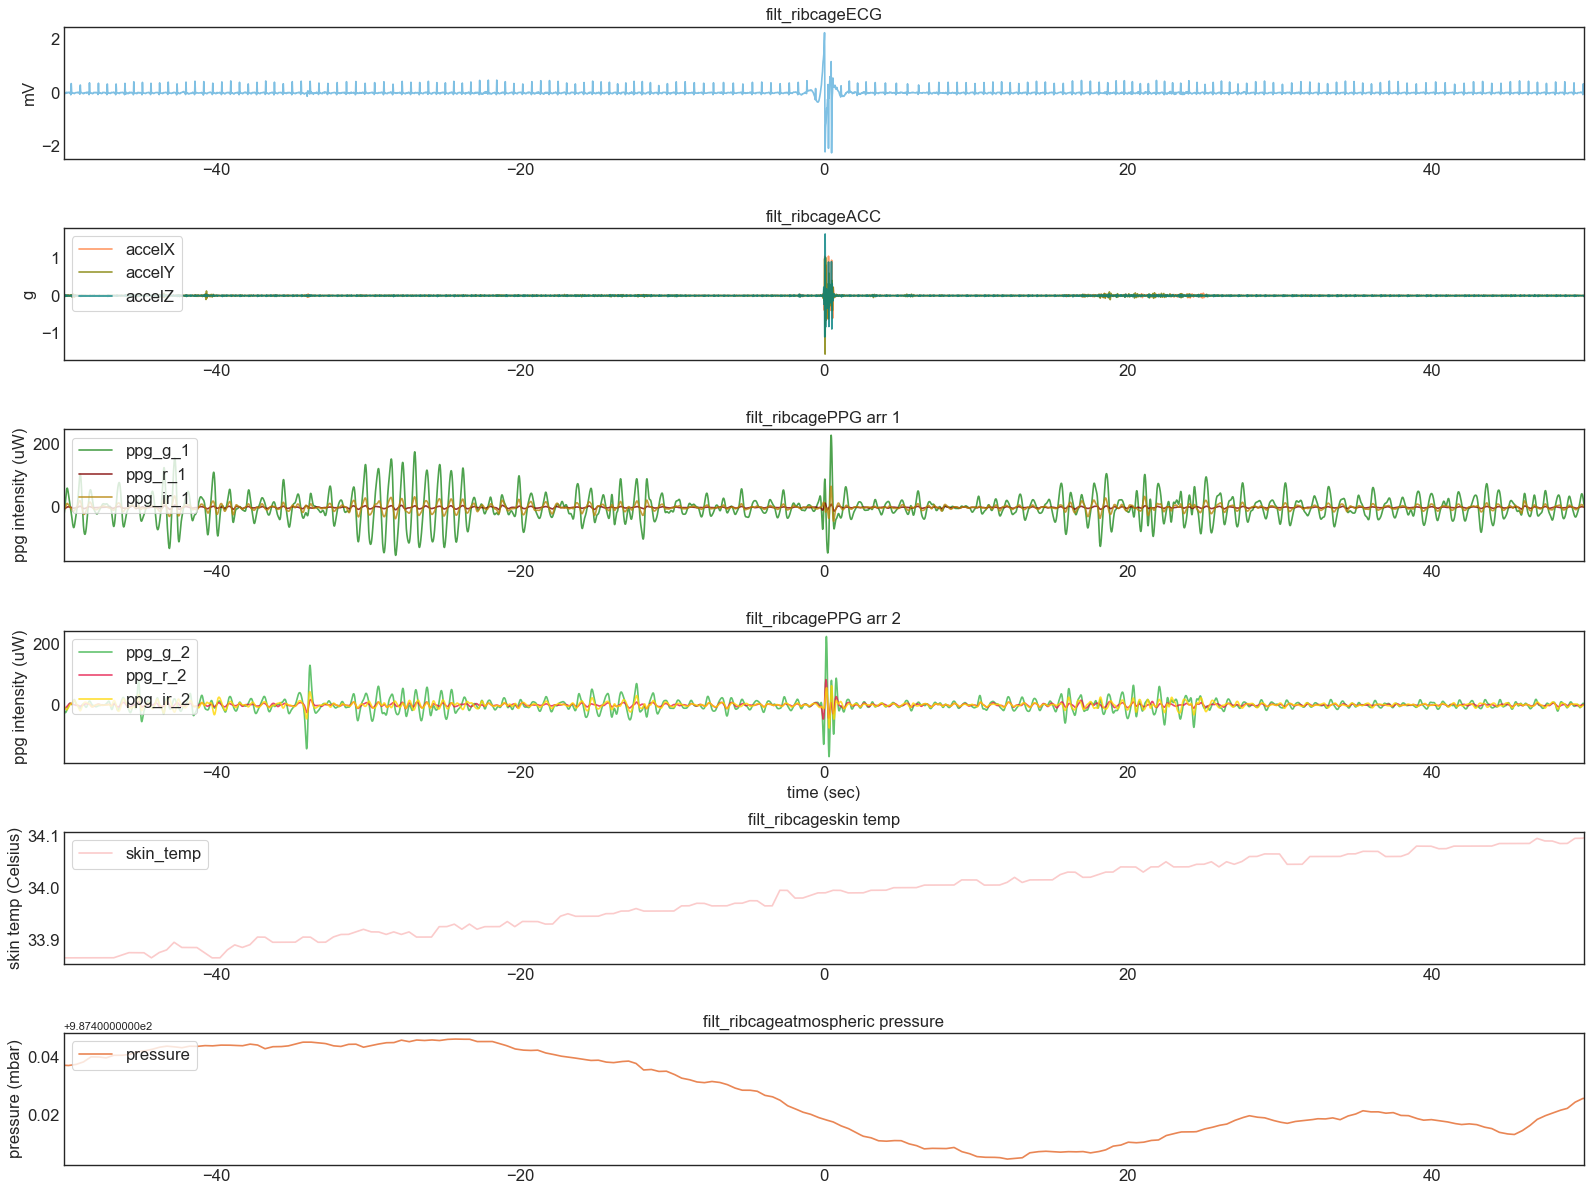

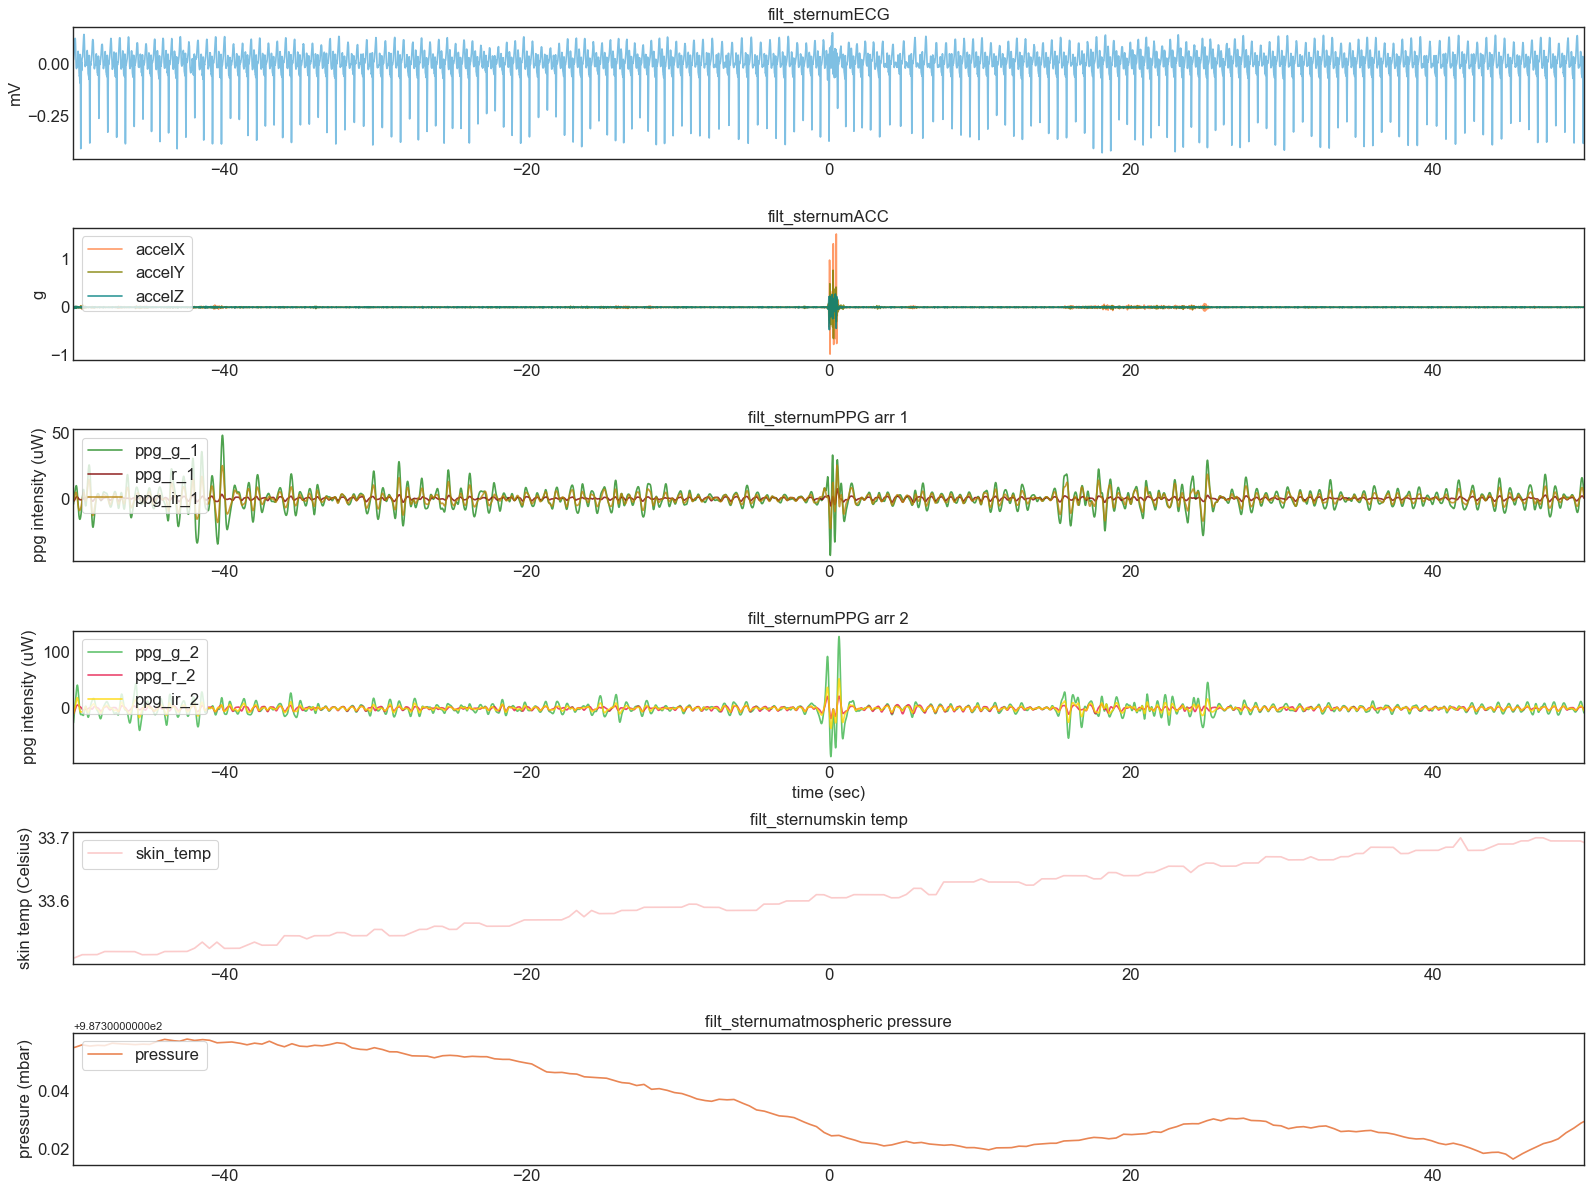

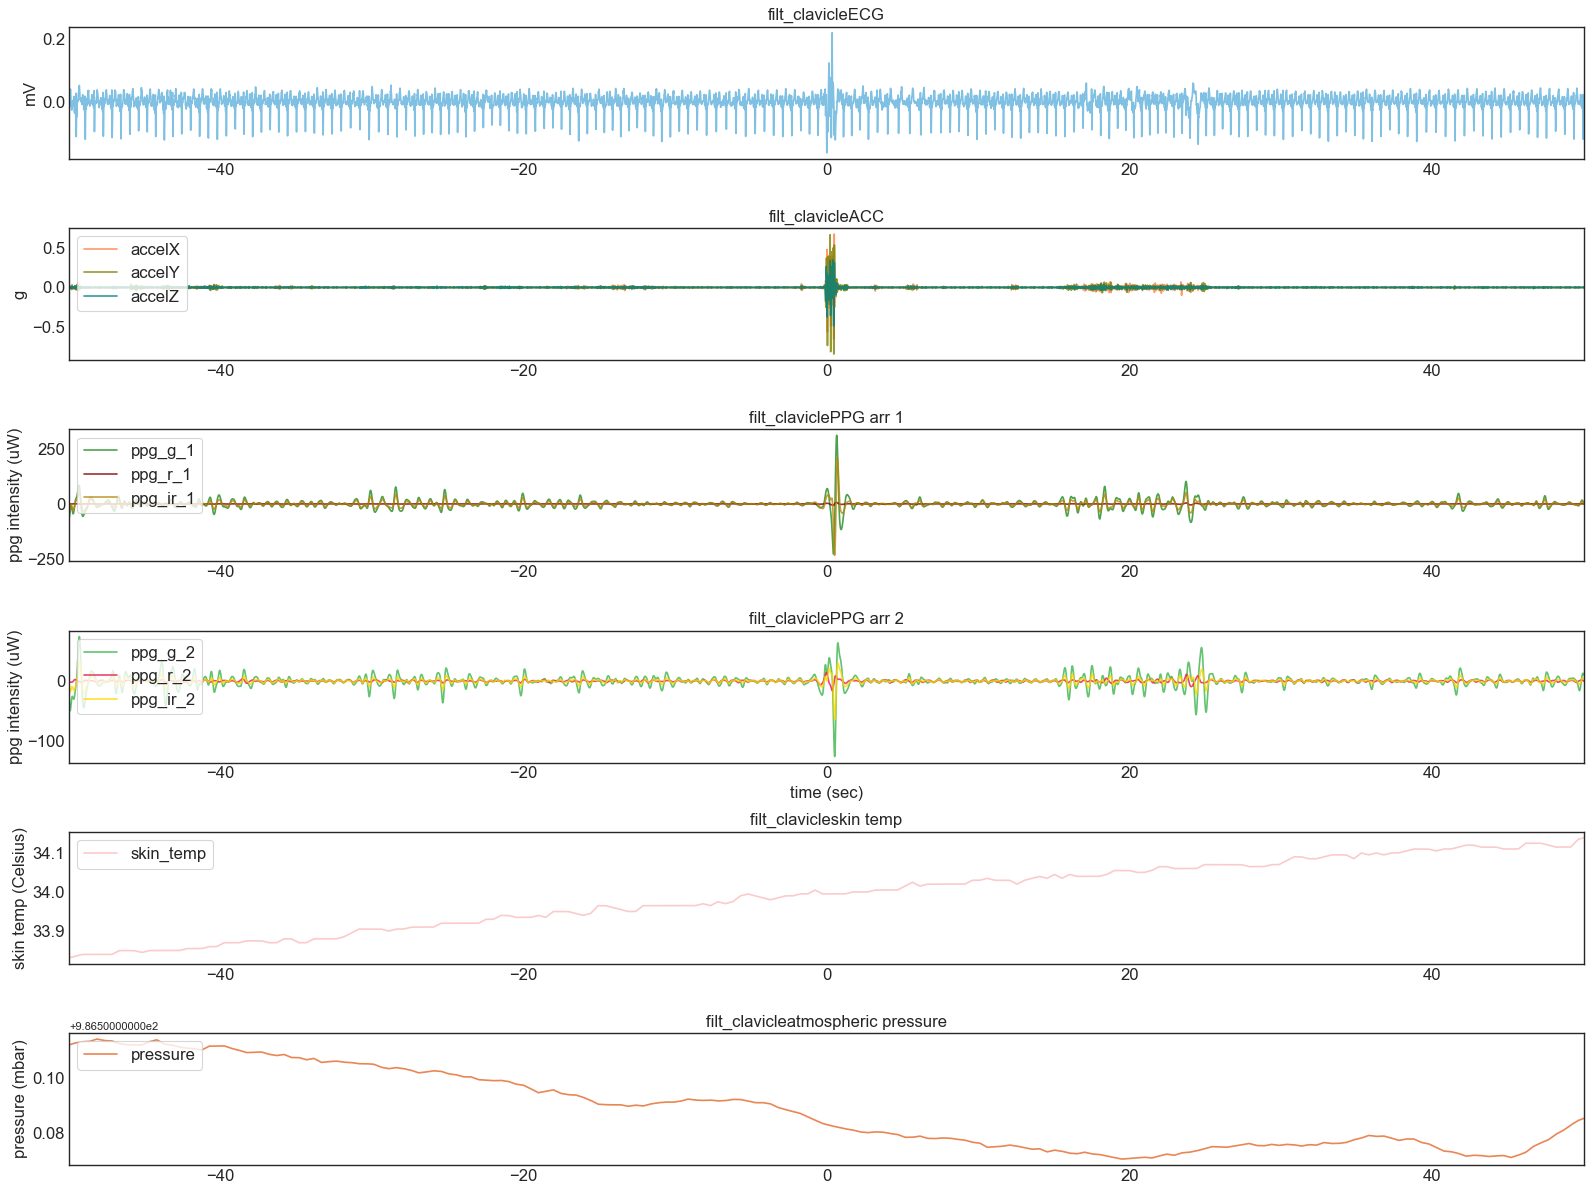

In [26]:
make_some_plot = True

if make_some_plot:
    for position in df_patch.keys():
        inspect_patch(get_filt_dict(df_patch[position]), title_str='filt_'+position, VIS_START=-50, VIS_END=50, outputdir=outputdir_sub, show_plot=True)
